# Data visualisation — Descriptives (Yields)

This notebook generates **descriptive visualisations** from the **raw yield dataset** (`Yields.csv`).
It is meant for quick exploration and sanity checks before modeling.

## What you’ll get
1. **Boxplots**: yield distribution for the **top crops** and **top municipalities**
2. **Heatmap**: **Municipality × Crop** density (counts)
3. **PCA/ACP**: a 2D projection to visualise structure after aggregating at **(Year, Municipality, Crop)** level

## Notes on “frequency”
When ranking crops/municipalities by frequency, the notebook treats each **Year × Municipality × Crop** combination as **one observation**,
even if multiple **Varieties** exist for that combination.

## Run order
Run the notebook **top → bottom**. Code cells are unchanged; this is purely a readability re-organization.

---
### Table of contents
- Parameters & paths
- Imports & helpers
- Load data
- Basic dataset info
- Boxplots
- Municipality × Crop heatmap
- Aggregate to (Year, Municipality, Crop)
- PCA / ACP
- PCA scatter views (overall and by crop)


## Parameters & paths
Edit these variables if you move files or want to change the notebook’s outputs.
- `DATA_DIR`: folder where inputs live
- `YIELDS_FILE` / `WEATHER_FILE`: input CSV paths
- `OUT_DIR`: where figures/results are saved (if enabled)


## 1) Boxplots
Distribution of yields for the most frequent crops/municipalities.
This is useful to spot outliers, skewness, and different dispersion patterns.


In [1]:
# === Parameters (easy to tweak) ===
DATA_DIR = "./data"   # keep the same logic as your existing notebook

YIELDS_FILE = f"{DATA_DIR}/Yields.csv"
WEATHER_FILE = f"{DATA_DIR}/Weather Reanalysis.csv"  # read for consistency (not used in the plots)

TOP_K = 10  # for boxplots

# Heatmap sizing: keep only the most frequent categories to avoid an unreadable huge heatmap
HEATMAP_TOP_MUNIS = 30
HEATMAP_TOP_CROPS = 30


## Imports & helper utilities
Libraries + small helpers used throughout the notebook.


## Aggregate to (Year, Municipality, Crop)
From this point on, the notebook **collapses varieties** and works at a cleaner panel level:
**Year × Municipality × Crop**.
This reduces duplication and makes multivariate methods (like PCA) more interpretable.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

def _standardize_str(s: pd.Series) -> pd.Series:
    # light standardization for consistent grouping/labels (does not change numeric data)
    return s.astype(str).str.strip().str.upper()

# --- Load files (same logic as data_visualisation.ipynb) ---
df_yields = pd.read_csv(YIELDS_FILE)
df_weather = pd.read_csv(WEATHER_FILE)

print("Yields shape:", df_yields.shape)
print("Weather shape:", df_weather.shape)

# Tidy column names (strip whitespace)
df_yields.columns = [c.strip() for c in df_yields.columns]
df_weather.columns = [c.strip() for c in df_weather.columns]

# Required columns
required = ["Year", "Municipality", "Crop"]
missing = [c for c in required if c not in df_yields.columns]
if missing:
    raise ValueError(f"Yields.csv is missing required columns: {missing}. Found: {list(df_yields.columns)}")

# Standardize keys for grouping (strings only)
df_yields = df_yields.copy()
df_yields["Municipality"] = _standardize_str(df_yields["Municipality"])
df_yields["Crop"] = _standardize_str(df_yields["Crop"])

# Keep only relevant columns for plotting (no feature engineering / no saving)
df_plot_raw = df_yields[["Year", "Municipality", "Crop", "Yield/Acre"]].dropna(subset=["Year", "Municipality", "Crop", "Yield/Acre"]).copy()

# Collapse varieties implicitly: unique (Year, Municipality, Crop)
# - this ensures frequency counts are independent of Variety
df_plot = (
    df_plot_raw
    .groupby(["Year", "Municipality", "Crop"], as_index=False)["Yield/Acre"]
    .mean()
)

print("Plot dataset shape (collapsed to Year×Municipality×Crop):", df_plot.shape)
df_plot.head()


Yields shape: (44448, 9)
Weather shape: (490896, 9)
Plot dataset shape (collapsed to Year×Municipality×Crop): (14476, 4)


,Year,Municipality,Crop,Yield/Acre
0,1996,ALEXANDER,ARGENTINE CANOLA,0.705
1,1996,ALEXANDER,BARLEY,1.607
2,1996,ALEXANDER,CANARYSEED,0.184
3,1996,ALEXANDER,OATS,1.215
4,1996,ALEXANDER,POLISH CANOLA,0.278


## Basic dataset info
Quick summary statistics (unique crops, municipalities, years, etc.) to validate that the data loaded correctly.


In [3]:
# === Basic dataset info ===

n_crops = df_yields["Crop"].nunique(dropna=True)
n_munis = df_yields["Municipality"].nunique(dropna=True)
print(f"- number of different crops: {n_crops}") # 53 crops expected
print(f"- number of different municipalities in df_yields: {n_munis}") # 99 municipalities expected

n_munis = df_weather["Municipality"].nunique(dropna=True)
print(f"- number of different municipalities in df_weather: {n_munis}") # 84 municipalities expected

# filter df_yields to contain the same municipalitys as in df_weather
munis_weather = df_weather["Municipality"].unique()
df_yields = df_yields[df_yields["Municipality"].isin(munis_weather)]
n_munis = df_yields["Municipality"].nunique(dropna=True)
print(f"- number of different municipalities after filtering: {n_munis}")

- number of different crops: 53
- number of different municipalities in df_yields: 99
- number of different municipalities in df_weather: 84
- number of different municipalities after filtering: 84


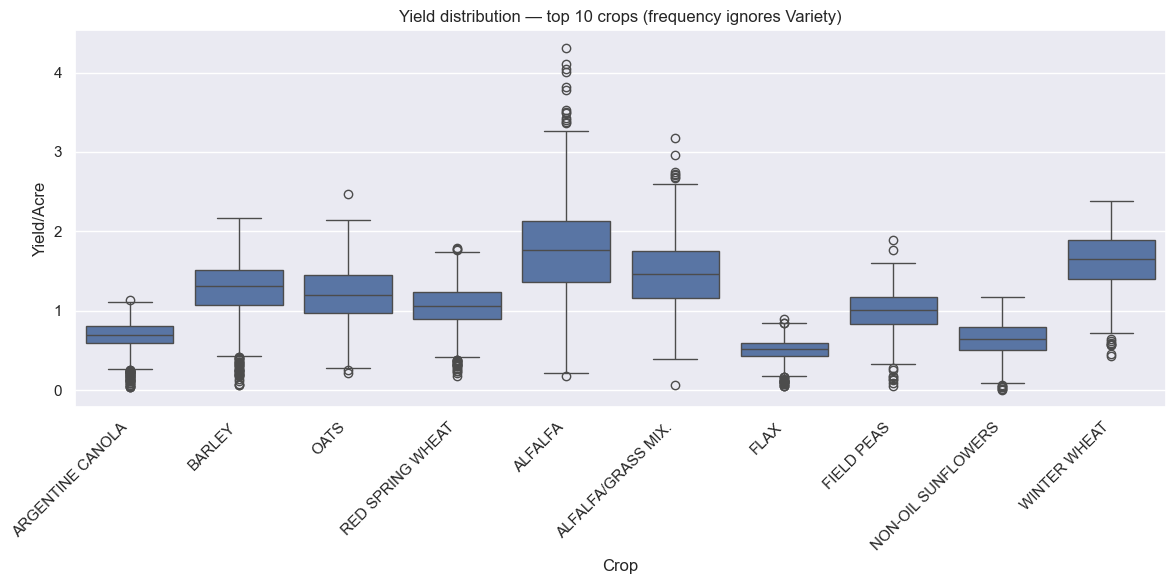

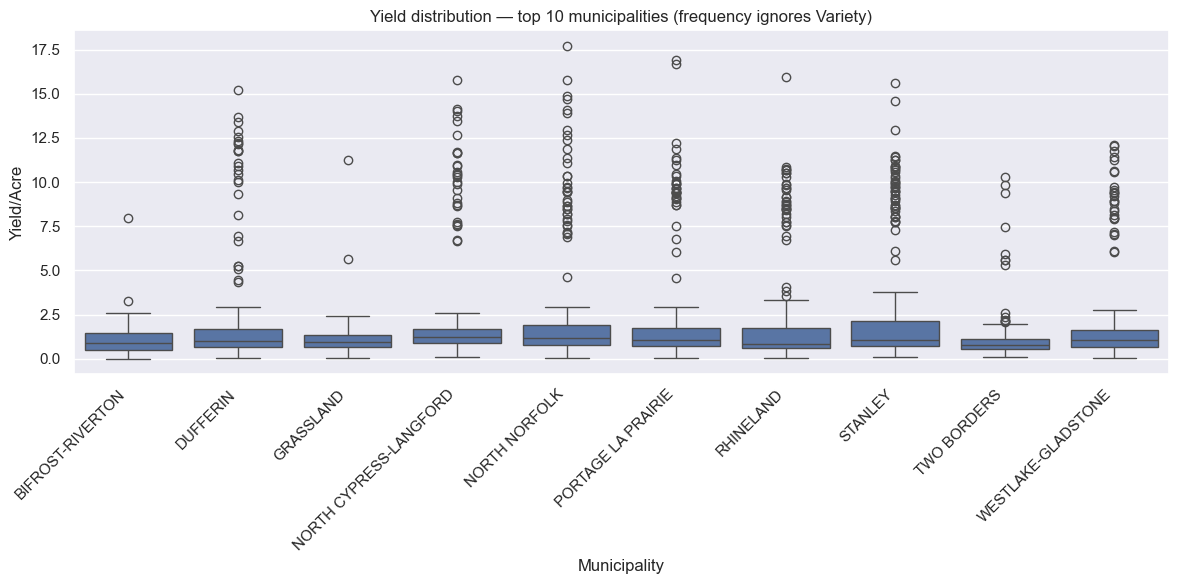

In [4]:
# === 1) Boxplots: yield distribution for TOP_K crops and municipalities ===

# Top crops by frequency (unique Year×Municipality×Crop)
top_crops = df_plot["Crop"].value_counts().head(TOP_K).index
df_top_crops = df_plot[df_plot["Crop"].isin(top_crops)].copy()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_top_crops, x="Crop", y="Yield/Acre")
plt.xticks(rotation=45, ha="right")
plt.title(f"Yield distribution — top {TOP_K} crops (frequency ignores Variety)")
plt.tight_layout()
plt.show()

# Top municipalities by frequency (unique Year×Municipality×Crop)
top_munis = df_plot["Municipality"].value_counts().head(TOP_K).index
df_top_munis = df_plot[df_plot["Municipality"].isin(top_munis)].copy()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_top_munis, x="Municipality", y="Yield/Acre")
plt.xticks(rotation=45, ha="right")
plt.title(f"Yield distribution — top {TOP_K} municipalities (frequency ignores Variety)")
plt.tight_layout()
plt.show()


## 2) Municipality × Crop heatmap (counts)
A density view of how observations are distributed across municipalities and crops.
Good for identifying sparse areas and dominant combinations.


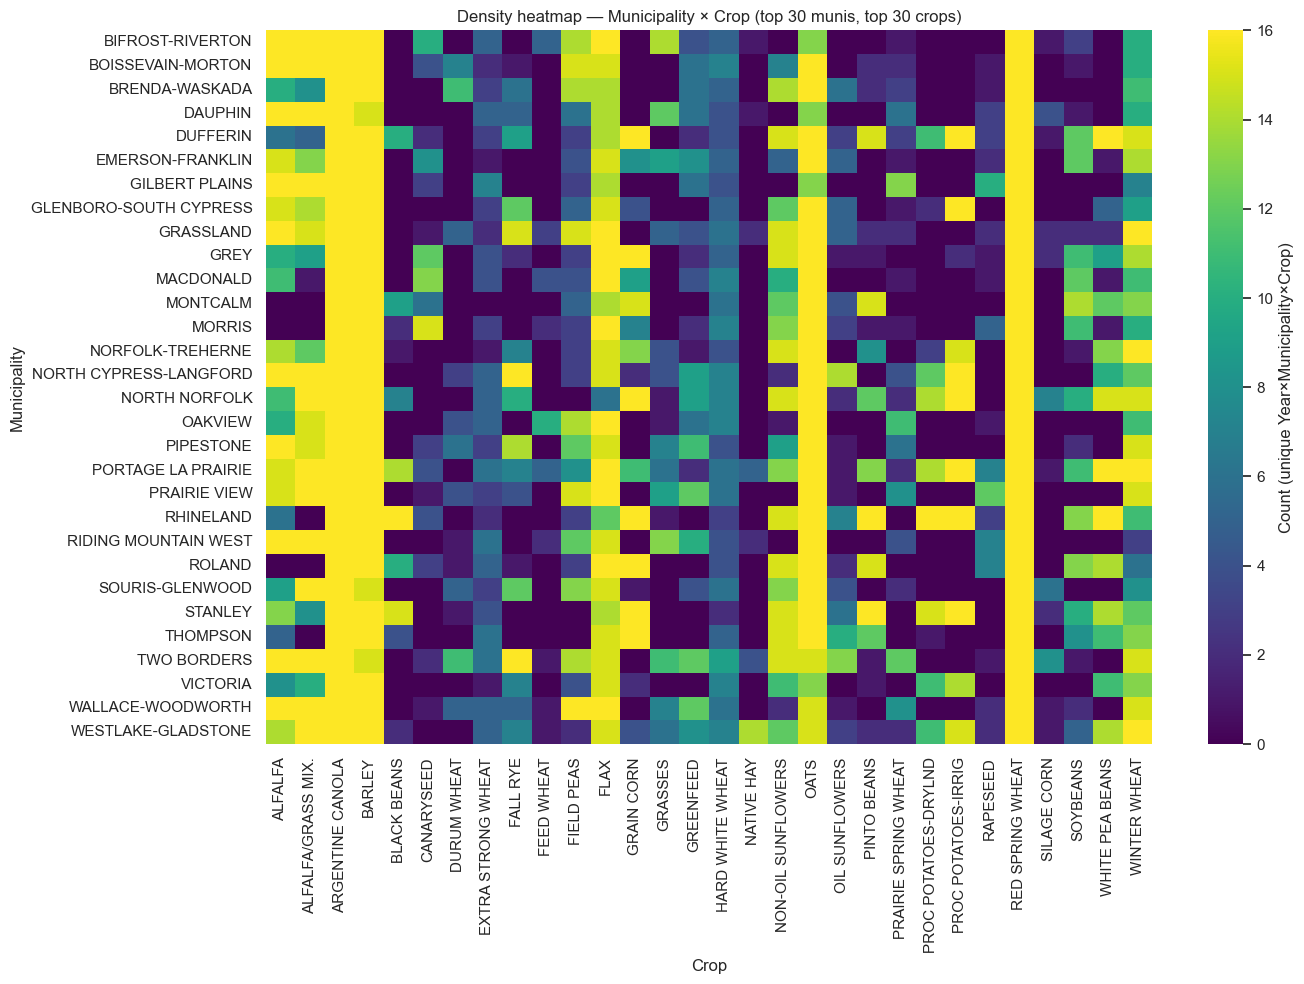

Heatmap table shape: (30, 30)


In [5]:
# === 2) Density heatmap: Municipality × Crop (counts) ===
# Counts are based on unique Year×Municipality×Crop, so they are independent of Variety.

# Choose most frequent municipalities/crops to keep the plot readable
muni_keep = df_plot["Municipality"].value_counts().head(HEATMAP_TOP_MUNIS).index
crop_keep = df_plot["Crop"].value_counts().head(HEATMAP_TOP_CROPS).index

df_hm = df_plot[df_plot["Municipality"].isin(muni_keep) & df_plot["Crop"].isin(crop_keep)].copy()

# Pivot to a count table
pivot_counts = df_hm.pivot_table(
    index="Municipality",
    columns="Crop",
    values="Yield/Acre",
    aggfunc="count",
    fill_value=0,
)

plt.figure(figsize=(14, 10))
sns.heatmap(pivot_counts, cmap="viridis", cbar_kws={"label": "Count (unique Year×Municipality×Crop)"})
plt.title(f"Density heatmap — Municipality × Crop (top {HEATMAP_TOP_MUNIS} munis, top {HEATMAP_TOP_CROPS} crops)")
plt.xlabel("Crop")
plt.ylabel("Municipality")
plt.tight_layout()
plt.show()

print("Heatmap table shape:", pivot_counts.shape)


🔝 Top 3 combinaisons Municipality + Crop :
     Municipality              Crop  count
1403   WHITEMOUTH  RED SPRING WHEAT     16
38         ARGYLE  RED SPRING WHEAT     16
1068       ROLAND            BARLEY     16


C:\Users\henri\AppData\Local\Temp\ipykernel_3736\3394213095.py:62: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\henri\Desktop\PSC\Data-study\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


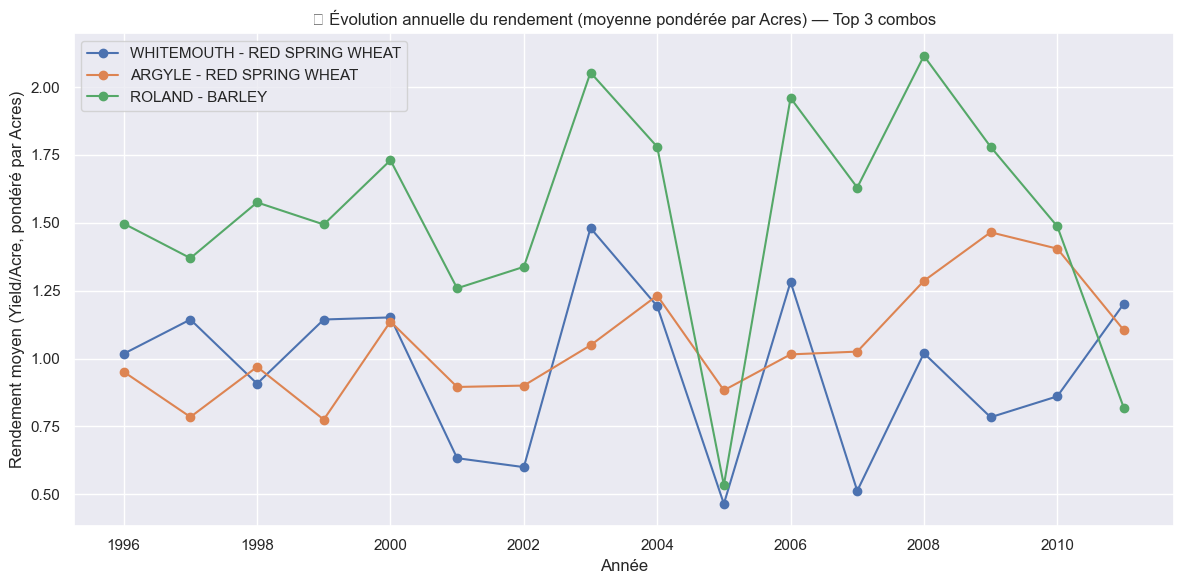

In [6]:
# --- 1) Collapse varieties: work at (Year, Municipality, Crop) level ---
df_base = (
    df_yields.groupby(["Year", "Municipality", "Crop"], as_index=False)
      .agg(
          Acres=("Acres", "sum"),
          YieldAcre_mean=("Yield/Acre", "mean")  # fallback if needed
      )
)

# Area-weighted mean yield per acre for each (Year, Municipality, Crop):
#   mean_yield = sum_i (yield_i * acres_i) / sum_i acres_i
tmp = df_yields.assign(_prod=df_yields["Yield/Acre"] * df_yields["Acres"])
df_weighted = (
    tmp.groupby(["Year", "Municipality", "Crop"], as_index=False)
       .agg(
           Acres=("Acres", "sum"),
           Prod=(" _prod".strip(), "sum")  # trick to keep simple; see below
       )
)
# If the "Prod" line above feels weird, just do it explicitly:
# df_weighted = (
#     tmp.groupby(["Year", "Municipality", "Crop"], as_index=False)
#        .agg(Acres=("Acres","sum"), Prod=("_prod","sum"))
# )

df_weighted["Mean_Yield"] = df_weighted["Prod"] / df_weighted["Acres"]

# --- 2) Top-3 most frequent Municipality×Crop combos (frequency independent of Variety) ---
combo_counts = (
    df_weighted.groupby(["Municipality", "Crop"], as_index=False)
               .size()
               .rename(columns={"size": "count"})
)
top3_combos = combo_counts.sort_values("count", ascending=False).head(3)

print("🔝 Top 3 combinaisons Municipality + Crop :")
print(top3_combos)

# --- 3) Plot annual evolution of mean yield for each top combo ---
plt.figure(figsize=(12, 6))

for _, row in top3_combos.iterrows():
    muni, crop = row["Municipality"], row["Crop"]
    df_subset = df_weighted[(df_weighted["Municipality"] == muni) & (df_weighted["Crop"] == crop)]

    df_year = (
        df_subset.groupby("Year", as_index=False)
                 .agg(
                     Acres=("Acres", "sum"),
                     Prod=("Prod", "sum")
                 )
    )
    df_year["Mean_Yield"] = df_year["Prod"] / df_year["Acres"]

    plt.plot(df_year["Year"], df_year["Mean_Yield"], marker="o", label=f"{muni} - {crop}")

plt.title("📈 Évolution annuelle du rendement (moyenne pondérée par Acres) — Top 3 combos")
plt.xlabel("Année")
plt.ylabel("Rendement moyen (Yield/Acre, pondéré par Acres)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## PCA / ACP (visualisation)
Principal Component Analysis projects the dataset into a low-dimensional space.
Here we use it **only for visualisation**, not for prediction.


## PCA scatter (overall)
Scatter plot in the (PC1, PC2) plane.
By default it uses `Mean_Yield` for point size/color if available in the code cell.


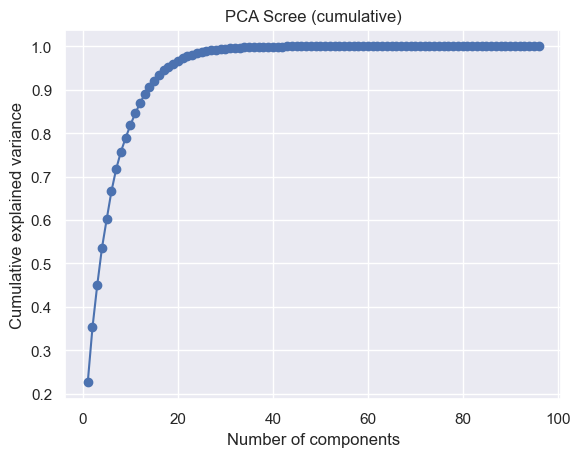

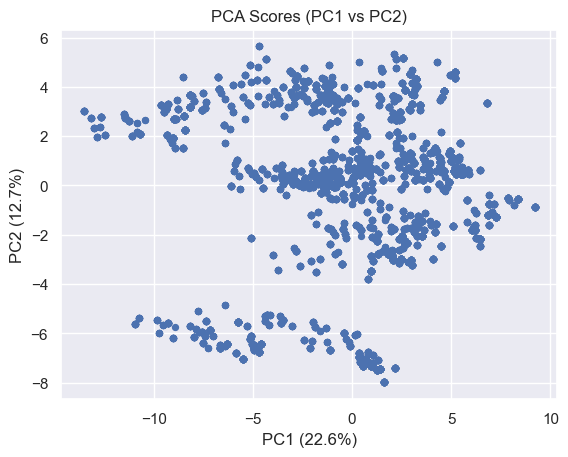

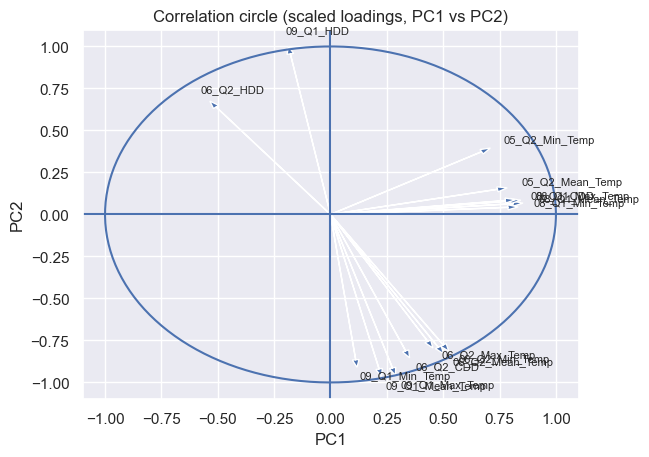

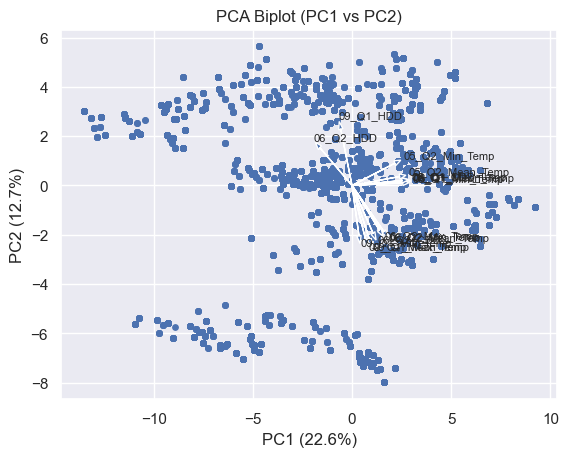

In [7]:
# =========================
# PCA / ACP (VISUALISATION)
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- CONFIG ----
TAG = "allcrops"          # must match what you saved
IN_DIR = "./prepared"

expl = pd.read_csv(f"{IN_DIR}/pca_explained_{TAG}.csv")
loadings = pd.read_csv(f"{IN_DIR}/pca_loadings_{TAG}.csv", index_col=0)
scores = pd.read_csv(f"{IN_DIR}/pca_scores_{TAG}.csv")

# ---- 1) Scree plot (cumulative explained variance) ----
plt.figure()
plt.plot(range(1, len(expl)+1), expl["explained_variance_ratio_cum"], marker="o")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.grid(True)
plt.title("PCA Scree (cumulative)")
plt.show()

# ---- Helper: get PC columns ----
pc_cols = [c for c in scores.columns if c.startswith("PC")]
# pick first 2
pcx, pcy = "PC1", "PC2"
if pcx not in scores.columns or pcy not in scores.columns:
    raise ValueError("PC1/PC2 not found in scores file. Check TAG/path.")

# ---- 2) PC scatter (observations) ----
plt.figure()
plt.scatter(scores[pcx], scores[pcy], s=18)
plt.xlabel(f"{pcx} ({expl.loc[0,'explained_variance_ratio']*100:.1f}%)")
plt.ylabel(f"{pcy} ({expl.loc[1,'explained_variance_ratio']*100:.1f}%)")
plt.grid(True)
plt.title("PCA Scores (PC1 vs PC2)")
plt.show()

# ---- 3) Correlation circle (approx) ----
# If X was standardized, a common approximation for correlation circle coordinates is:
# corr(var, PCk) ≈ loading(var, PCk) * sqrt(eigenvalue_k)
# We don't have eigenvalues saved, but we can approximate using explained variance ratio times total variance.
# A robust alternative: just plot loadings and scale to fit inside [-1,1].

# --- Reduce clutter: show only top variables for PC1/PC2 ---
TOP_N = 15  # try 10, 15, 20

pcx, pcy = "PC1", "PC2"

L = loadings[[pcx, pcy]].copy()

# Importance in the PC1-PC2 plane (bigger = more influential on the plot)
importance = (L[pcx]**2 + L[pcy]**2)

top_vars = importance.sort_values(ascending=False).head(TOP_N).index
L = L.loc[top_vars]


# scale arrows so they fit nicely (visual scaling, not changing meaning)
max_abs = np.abs(L.values).max()
scale = 1.0 / max_abs if max_abs > 0 else 1.0
L_plot = L * scale

plt.figure()
# unit circle
theta = np.linspace(0, 2*np.pi, 300)
plt.plot(np.cos(theta), np.sin(theta))
plt.axhline(0)
plt.axvline(0)

for var in L_plot.index:
    x, y = L_plot.loc[var, pcx], L_plot.loc[var, pcy]
    plt.arrow(0, 0, x, y, head_width=0.03, length_includes_head=True)
    plt.text(x*1.08, y*1.08, var, fontsize=8)

plt.xlabel(pcx)
plt.ylabel(pcy)
plt.title("Correlation circle (scaled loadings, PC1 vs PC2)")
plt.grid(True)
plt.show()

# ---- 4) Biplot (scores + variable directions) ----
# We'll overlay arrows from loadings (scaled) on the score plot.


plt.figure()
plt.scatter(scores[pcx], scores[pcy], s=15)

# scale arrows to match score spread
sx = scores[pcx].std()
sy = scores[pcy].std()
arrow_scale = 0.8  # tweak if too big/small

for var in L_plot.index:
    x, y = L_plot.loc[var, pcx], L_plot.loc[var, pcy]
    plt.arrow(0, 0, x*sx*arrow_scale, y*sy*arrow_scale, head_width=0.05*sx, length_includes_head=True)
    plt.text(x*sx*arrow_scale*1.05, y*sy*arrow_scale*1.05, var, fontsize=8)

plt.xlabel(f"{pcx} ({expl.loc[0,'explained_variance_ratio']*100:.1f}%)")
plt.ylabel(f"{pcy} ({expl.loc[1,'explained_variance_ratio']*100:.1f}%)")
plt.grid(True)
plt.title("PCA Biplot (PC1 vs PC2)")
plt.show()

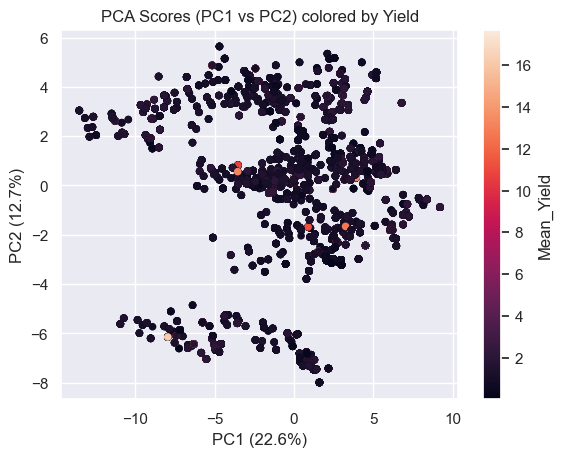

In [8]:
pcx, pcy = "PC1", "PC2"
yield_col = "Mean_Yield"   # change if your column name differs

# Keep only rows where yield exists
plot_df = scores.dropna(subset=[pcx, pcy, yield_col]).copy()

plt.figure()
sc = plt.scatter(plot_df[pcx], plot_df[pcy], s=20, c=plot_df[yield_col])
plt.xlabel(f"{pcx} ({expl.loc[0,'explained_variance_ratio']*100:.1f}%)")
plt.ylabel(f"{pcy} ({expl.loc[1,'explained_variance_ratio']*100:.1f}%)")
plt.title("PCA Scores (PC1 vs PC2) colored by Yield")
plt.grid(True)
cbar = plt.colorbar(sc)
cbar.set_label(yield_col)
plt.show()

## PCA scatter (split by crop)
Same projection, but faceted/looped by crop to visually compare crop-specific structure.


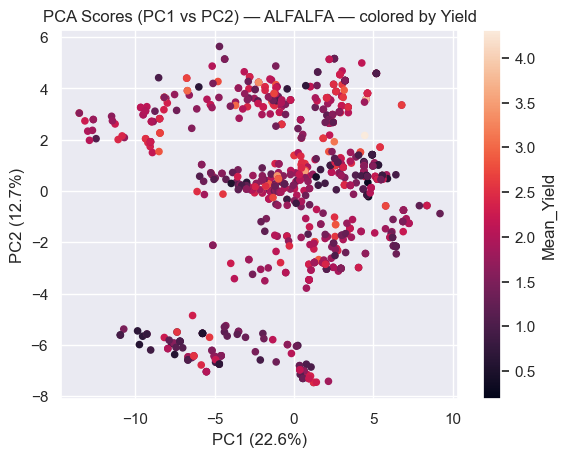

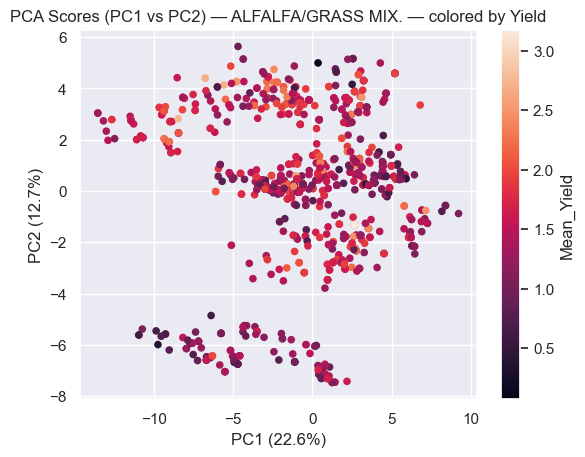

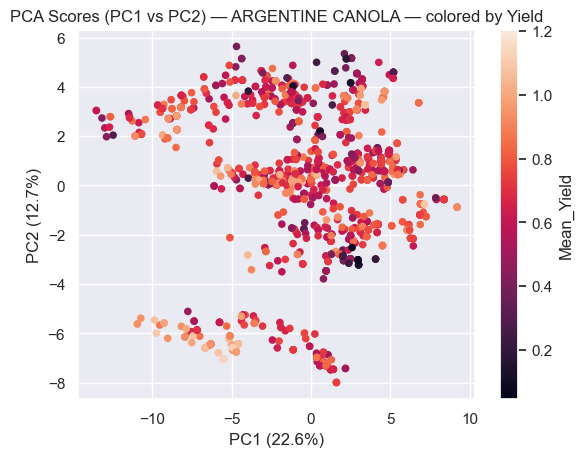

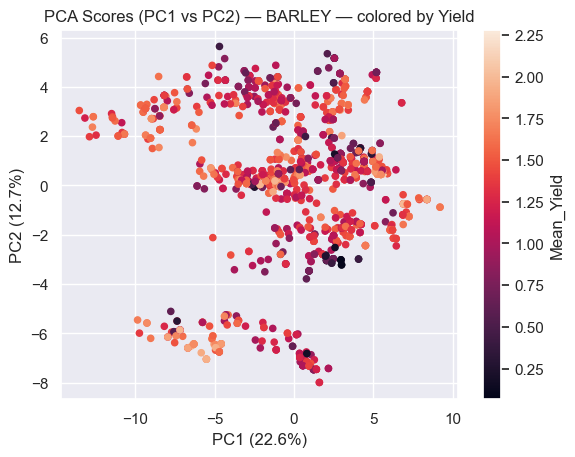

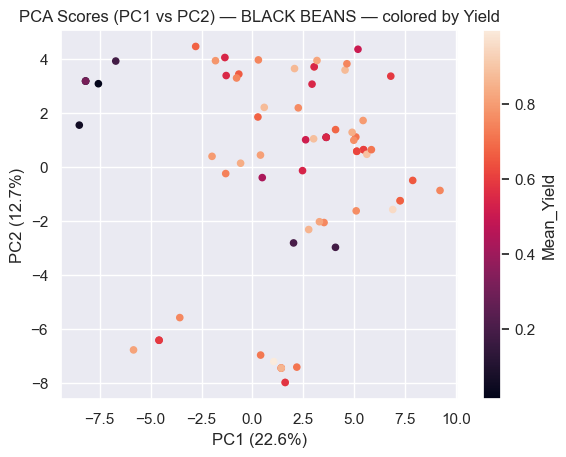

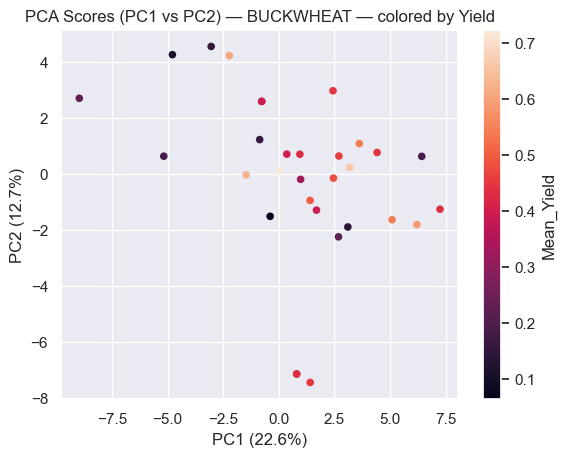

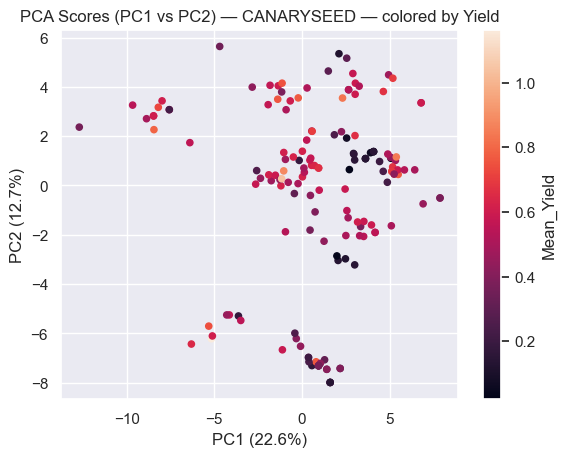

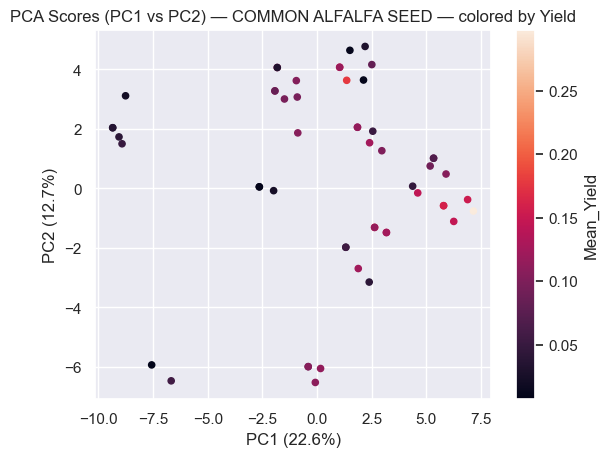

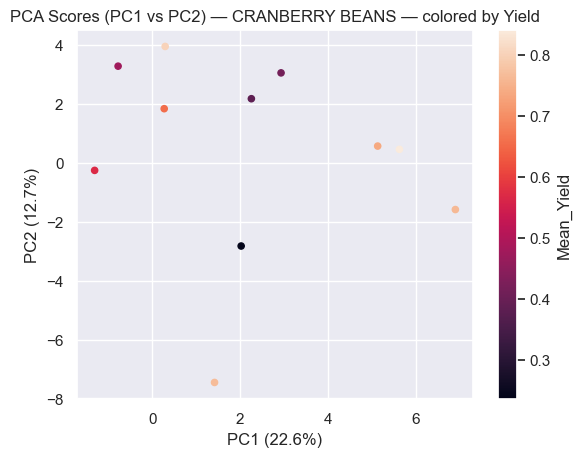

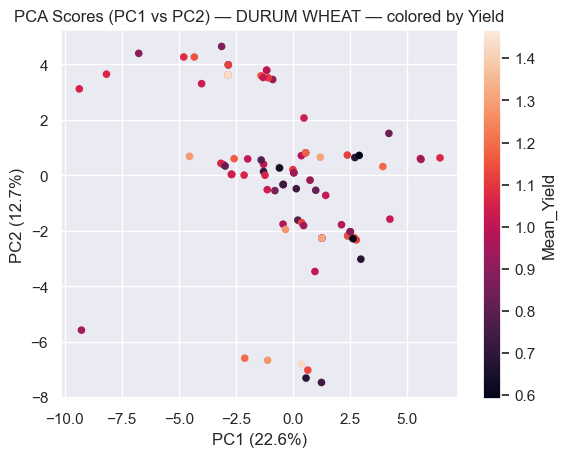

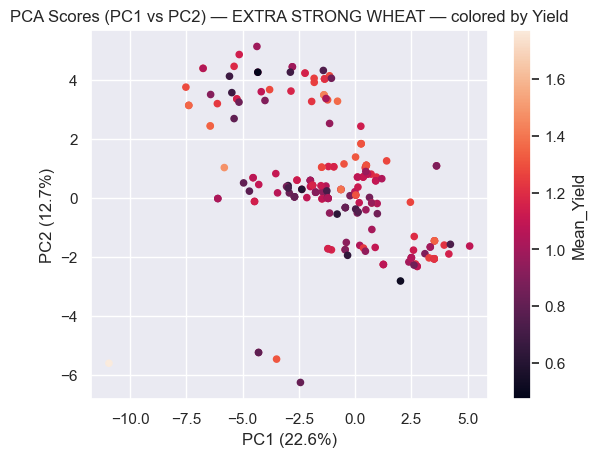

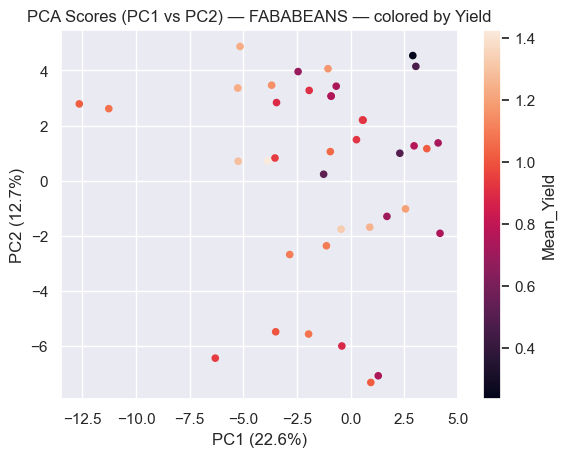

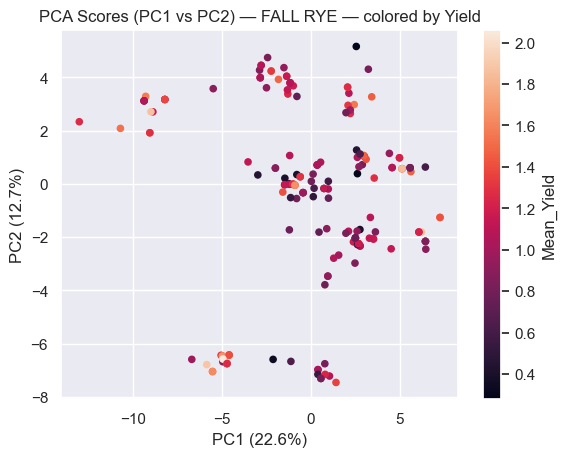

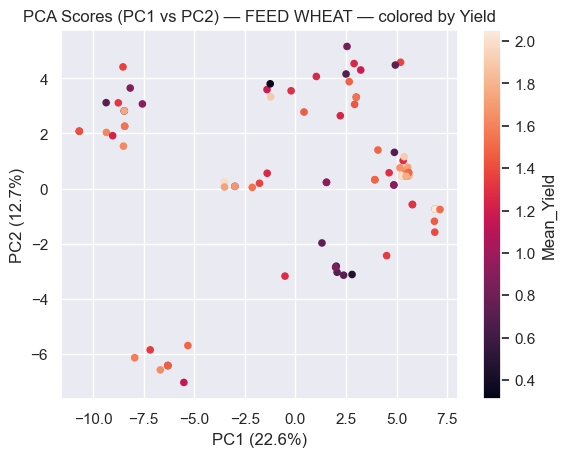

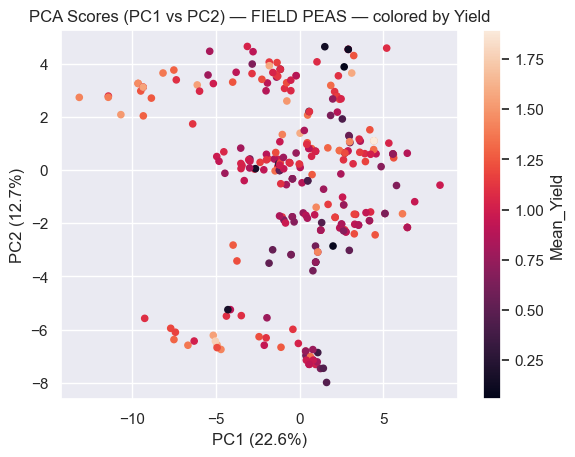

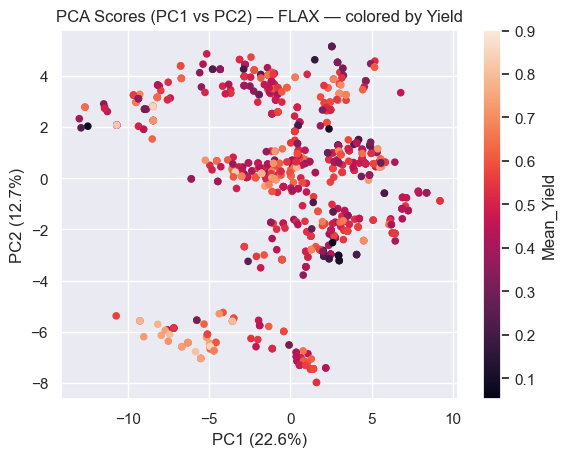

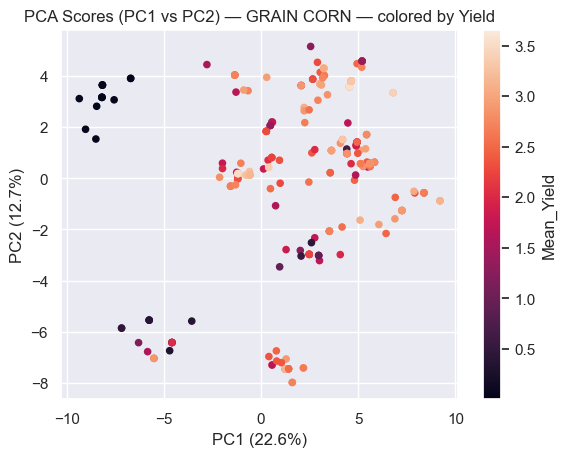

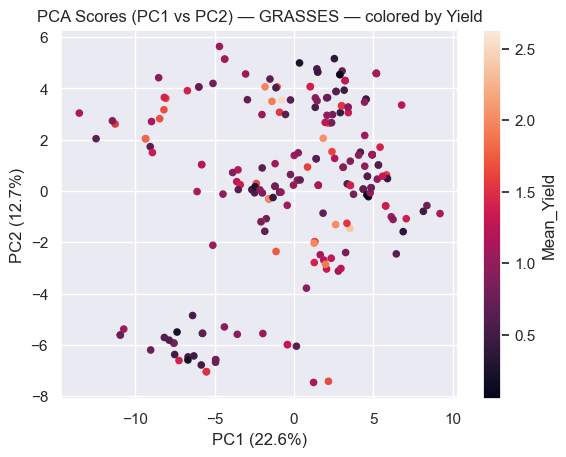

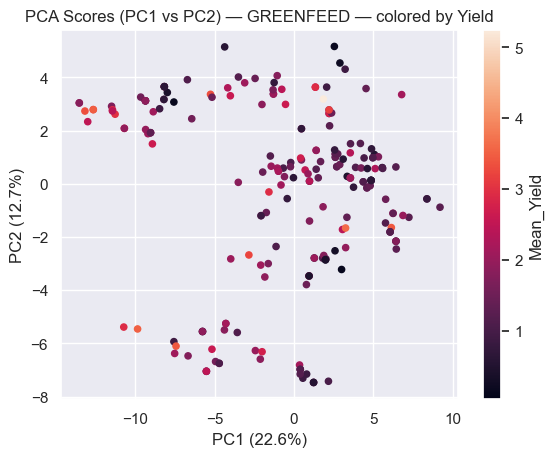

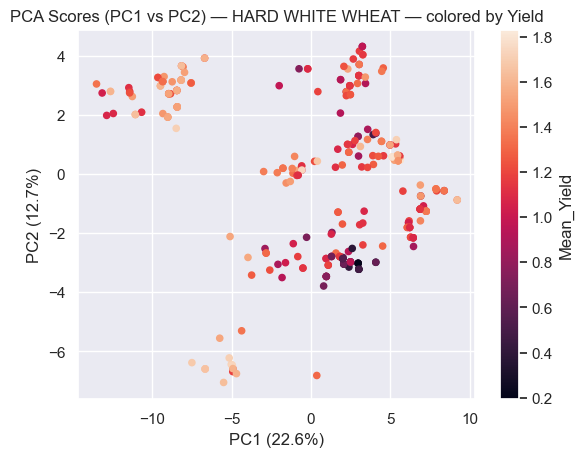

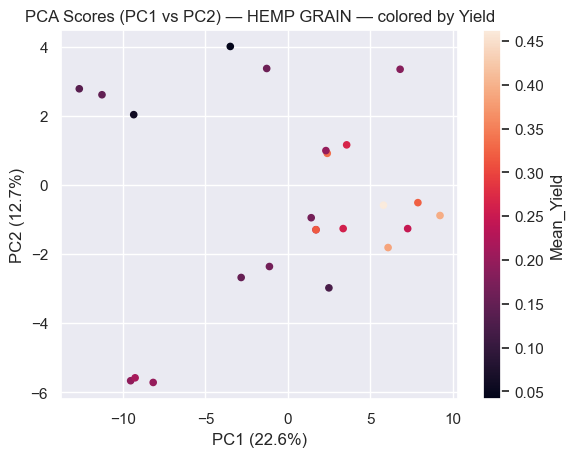

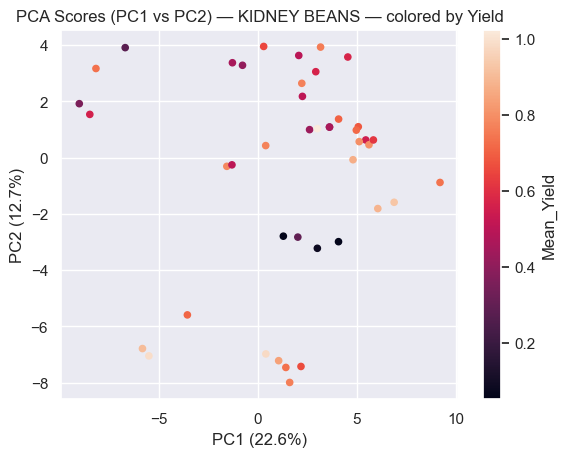

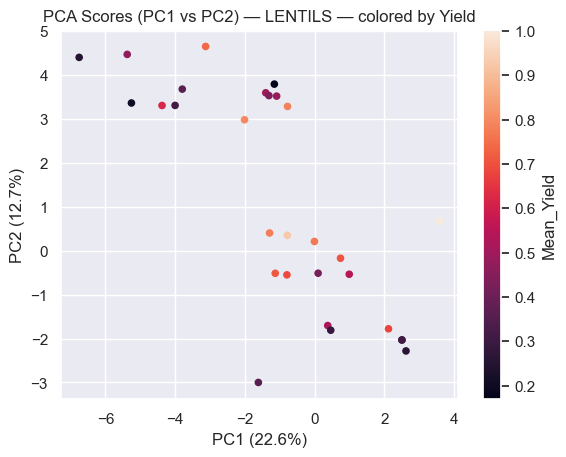

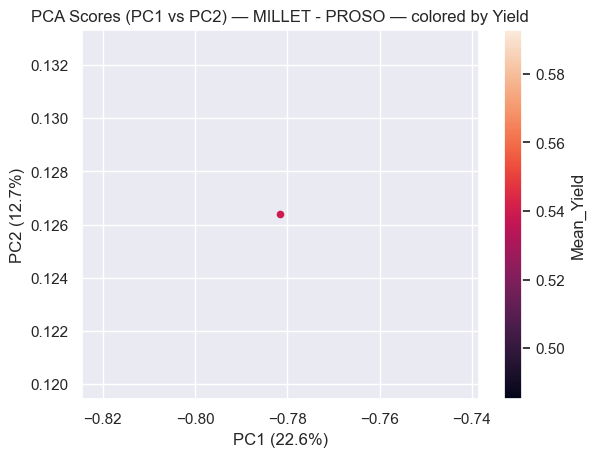

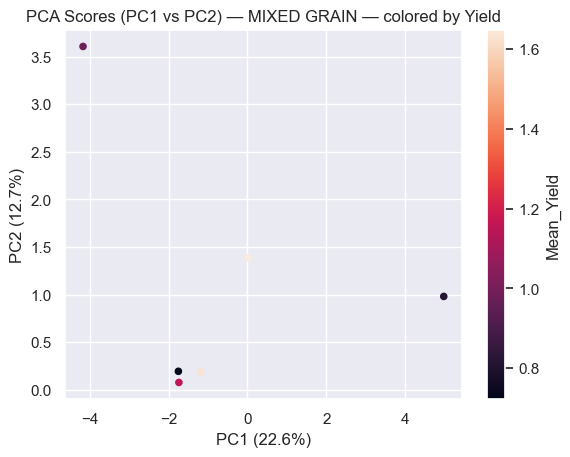

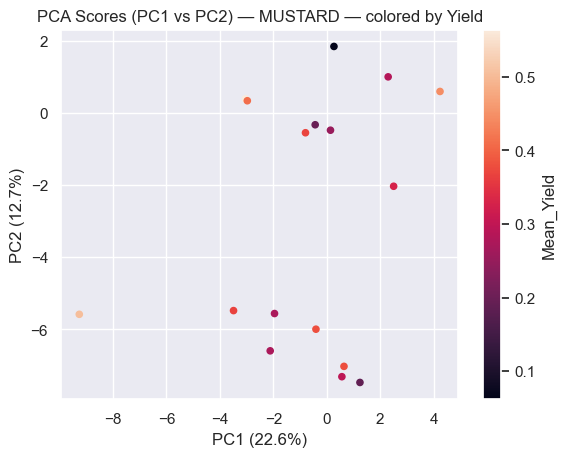

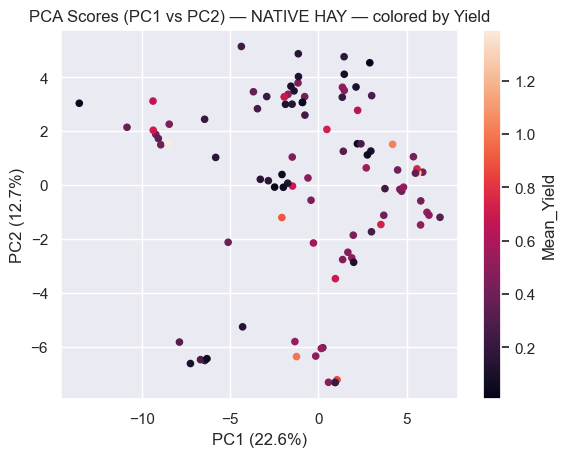

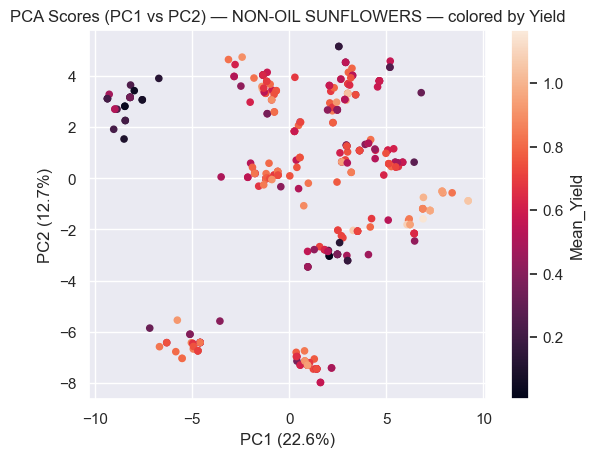

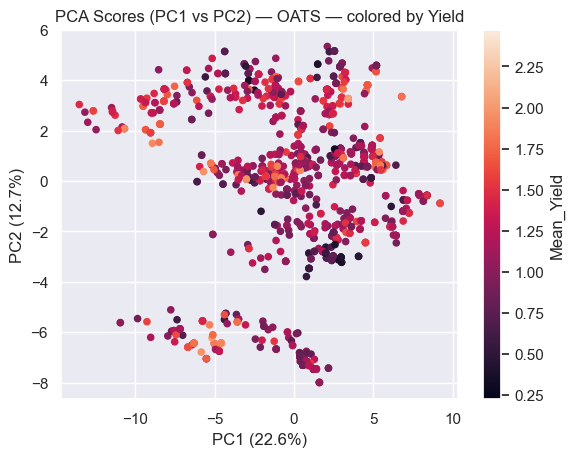

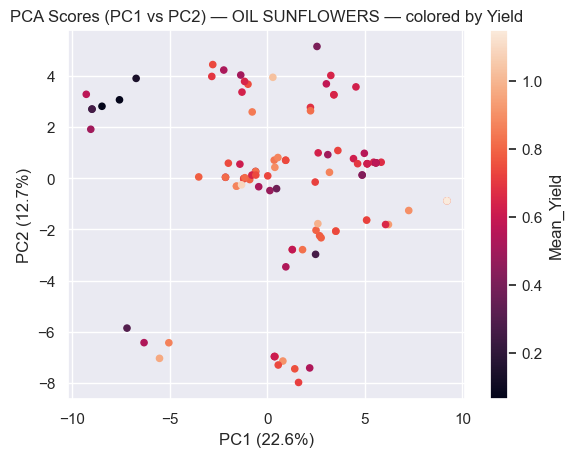

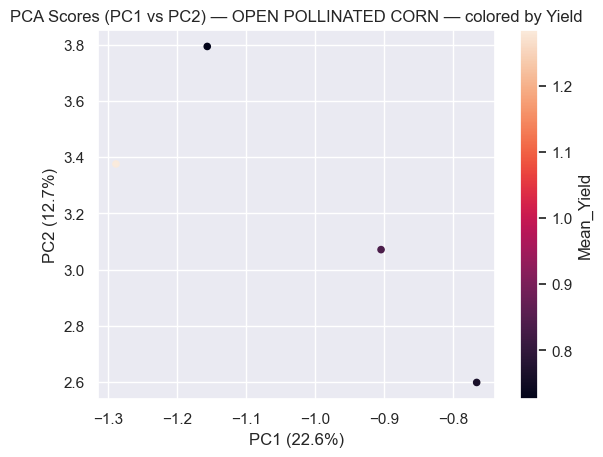

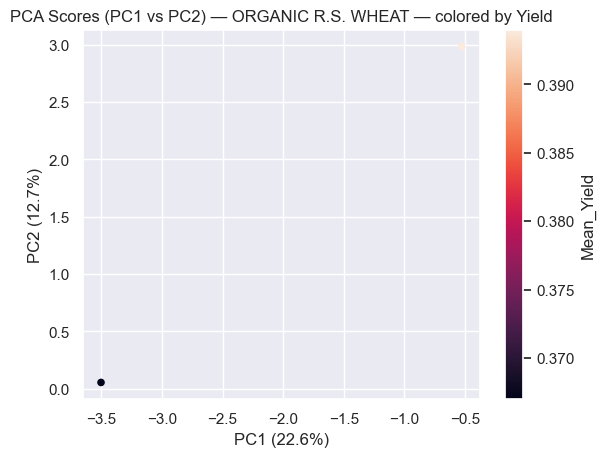

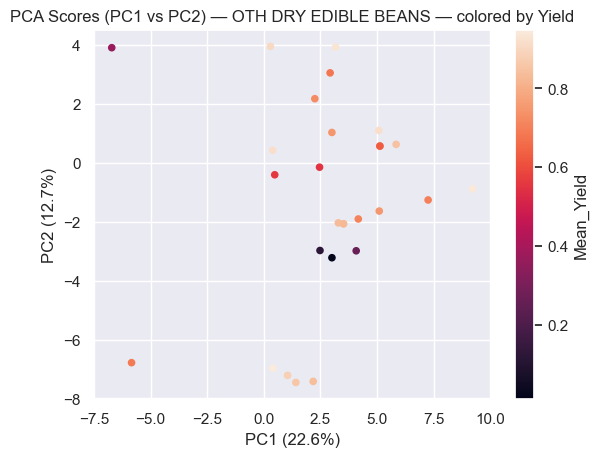

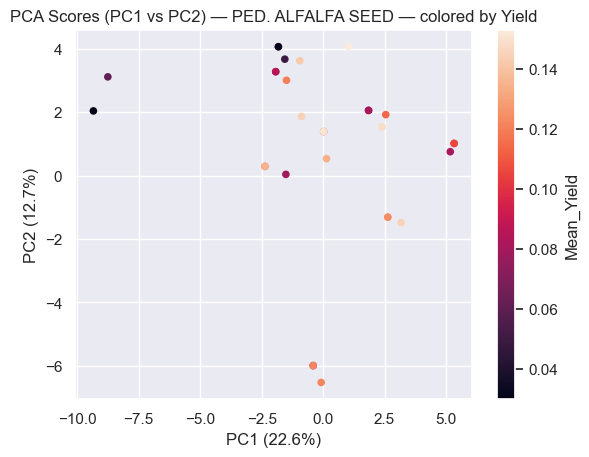

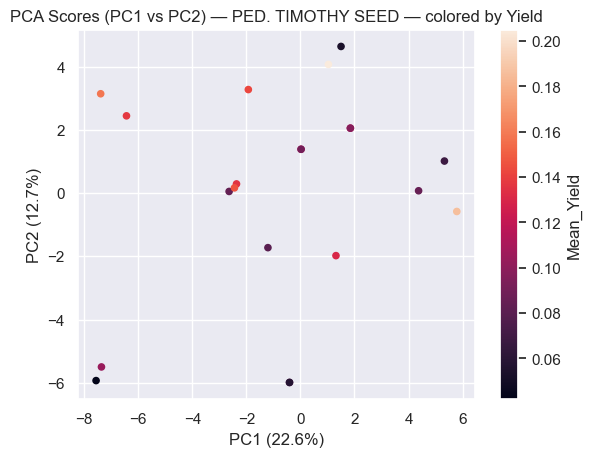

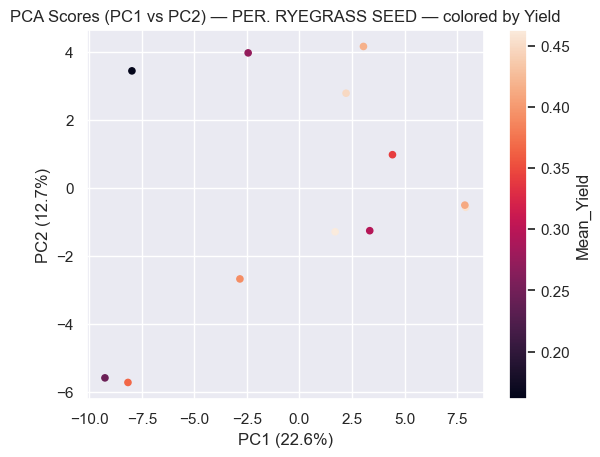

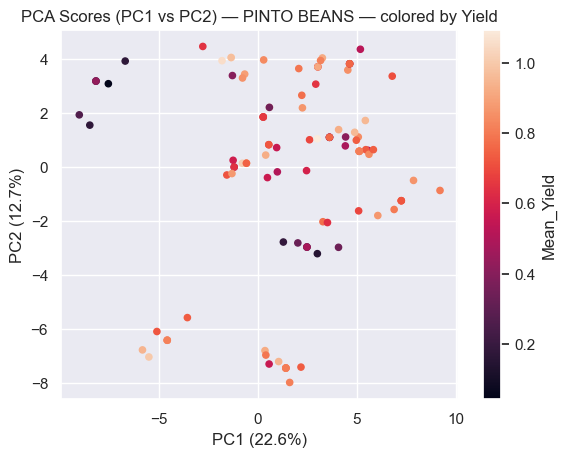

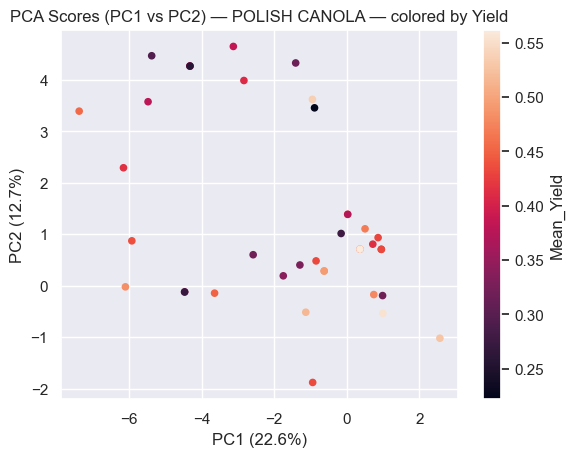

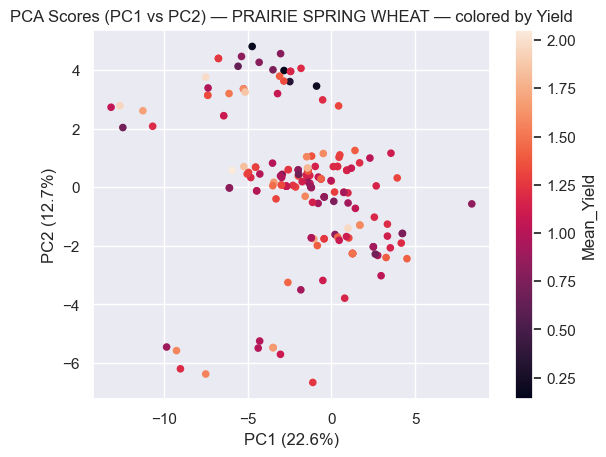

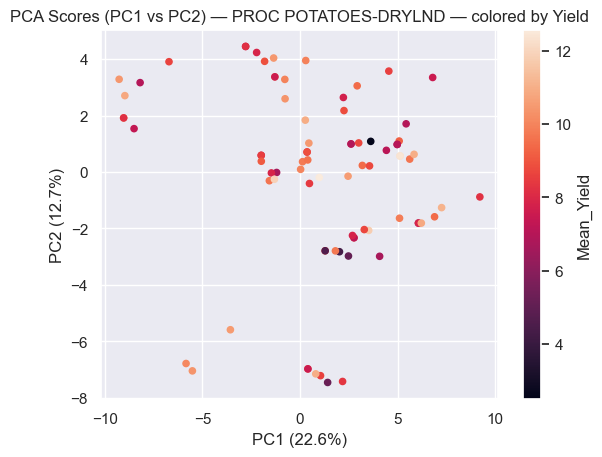

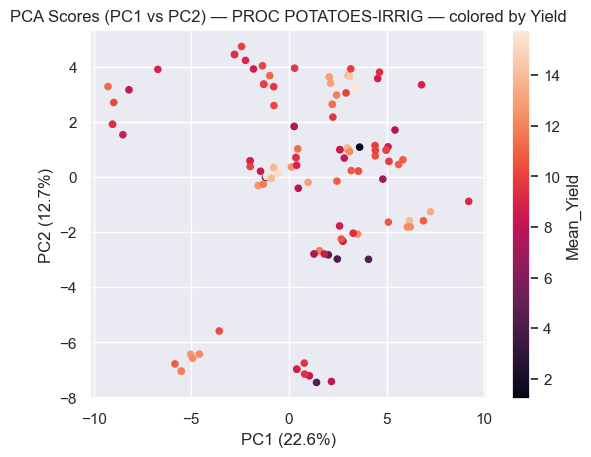

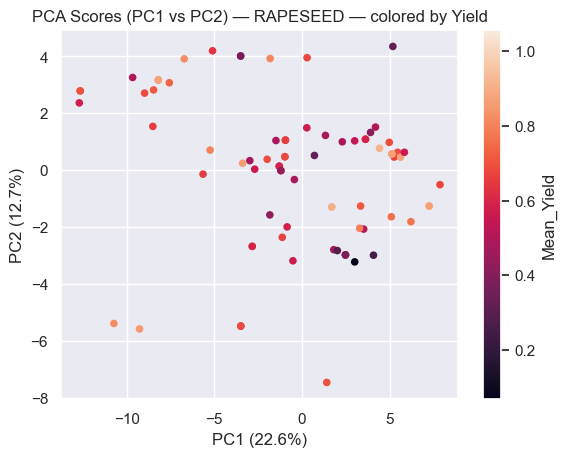

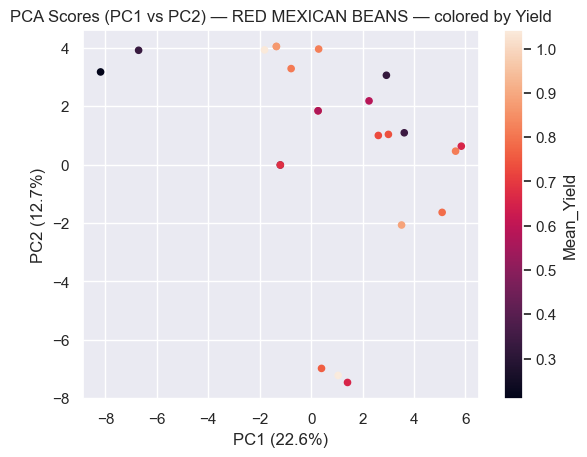

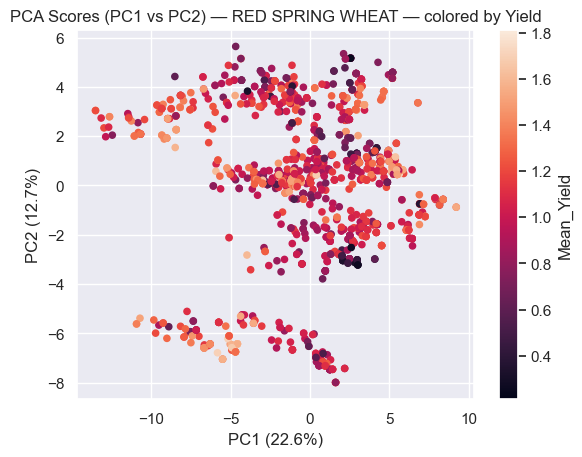

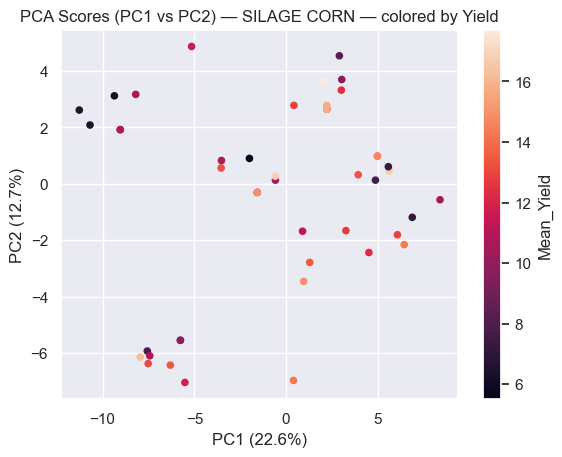

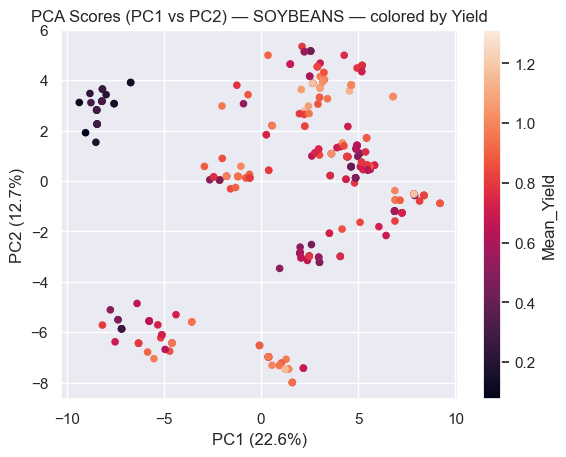

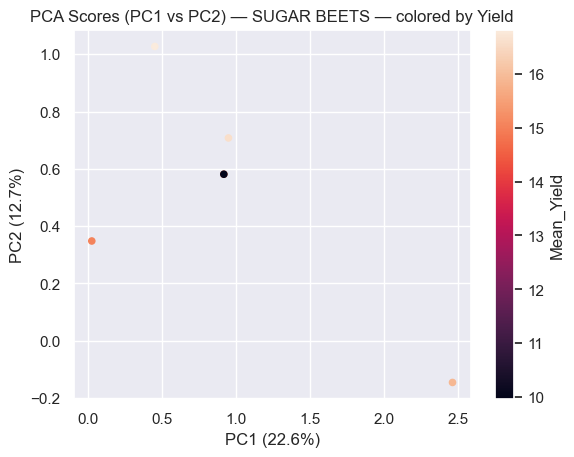

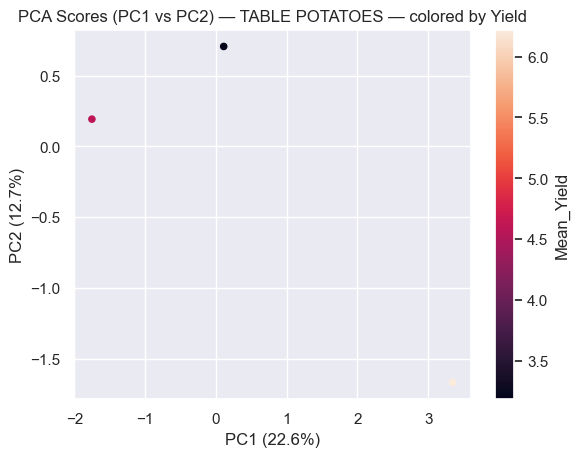

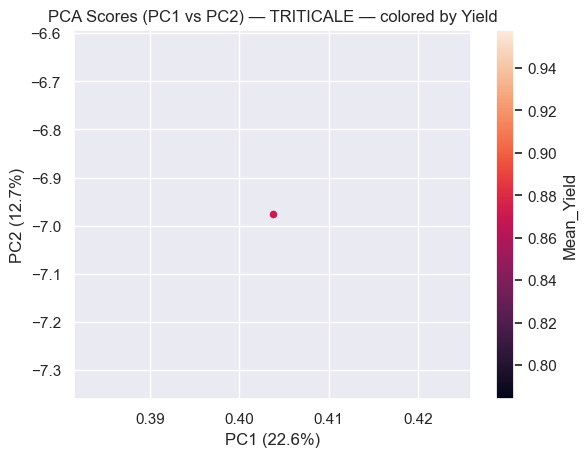

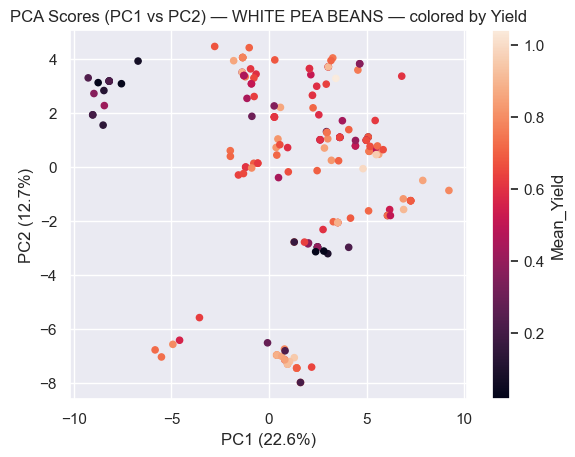

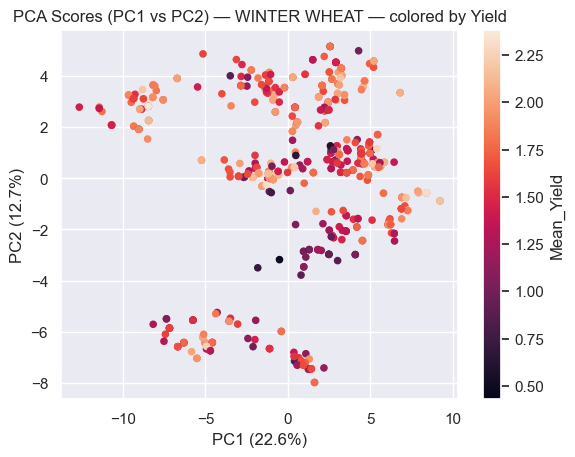

In [9]:
pcx, pcy = "PC1", "PC2"
yield_col = "Mean_Yield"
crop_col = "Crop"

plot_df = scores.dropna(subset=[pcx, pcy, yield_col]).copy()

for crop, g in plot_df.groupby(crop_col):
    plt.figure()
    sc = plt.scatter(g[pcx], g[pcy], s=20, c=g[yield_col])
    plt.xlabel(f"{pcx} ({expl.loc[0,'explained_variance_ratio']*100:.1f}%)")
    plt.ylabel(f"{pcy} ({expl.loc[1,'explained_variance_ratio']*100:.1f}%)")
    plt.title(f"PCA Scores (PC1 vs PC2) — {crop} — colored by Yield")
    plt.grid(True)
    cbar = plt.colorbar(sc)
    cbar.set_label(yield_col)
    plt.show()